In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.stats.api as sm

C:\Users\user\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10

Считываем данные

In [3]:
wine = pd.read_csv('wine_data.csv', sep='\t', header=0)
wine = wine.sample(frac=1)

Выводим распределение экспертных оценок вин в выборке

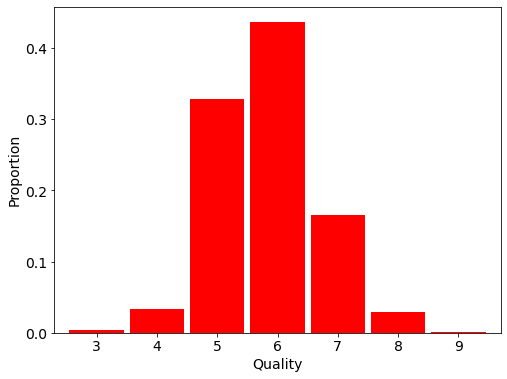

In [4]:
plt.figure(figsize=(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)
plt.show()

Узнаем, какую оценку получит новое вино, которого в выборке нет. Обучим модели, иными словами

Отделим 25% выборки для контроля качества предсказания

In [5]:
X_train, X_test, y_train, y_test = train_test_split(wine.loc[:, wine.columns != 'quality'], wine['quality'], test_size=0.25, 
                                                    stratify=wine[['Type', 'quality']])

In [6]:
X_train['Type'] = X_train['Type'].apply(lambda x : -1 if x == 'red' else 1)
X_test['Type'] = X_test['Type'].apply(lambda x : -1 if x == 'red' else 1)

Если нет больше никакой информации о винах, то наше лучшее предположение об оценке - это среднее имеющихся в обучающей выборке

In [7]:
np.mean(y_train)

5.817733990147783

Если будем предсказывать этой величиной оценку всех вин, на обучающей выборке получим среднеквадратичную ошибку (MSE)

In [8]:
mean_squared_error([np.mean(y_train)]*len(y_train), y_train)**0.5

0.8735940831862377

а на тестовой

In [9]:
mean_squared_error([np.mean(y_train)]*len(y_test), y_test)**0.5

0.8719705746838052

На тестовой выборке ошибка больше, поскольку среднее оценивали по обучающей

Информация о типе вина:

In [10]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

Распределения оценок по типам довольно сильно отличаются

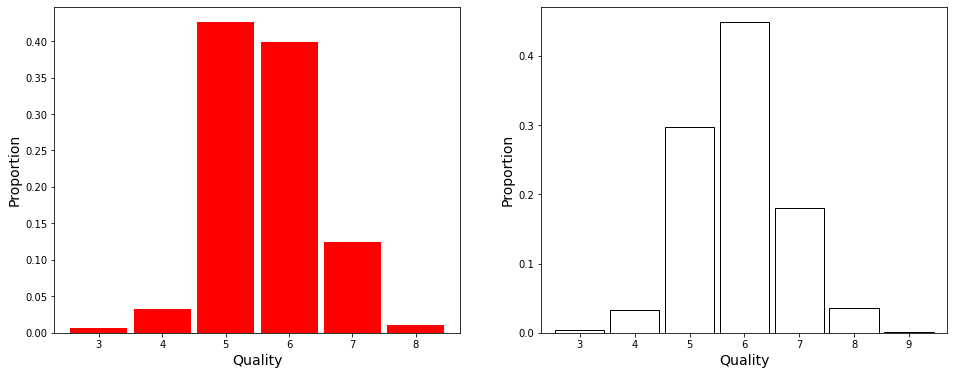

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(121)
stat_red = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot(kind='bar', color='w',edgecolor = 'black', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)
plt.show()

In [12]:
tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['Type'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['Type'] == 'red']['quality']))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]
# различие между средними статистически значимо

4.888069044202176e-22

95% доверительный интервал для разности средних оценок

In [13]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.19293009404017958, 0.29084357932805205)

Для уточнения предсказания, можно оценку каждого вина предсказывать средним по оценкам вин такого же типа в выборке

In [14]:
regressor = LinearRegression() # используем регрессию
regressor.fit(X_train['Type'].values.reshape(-1,1), y_train)

LinearRegression()

In [15]:
y_train_predictions = regressor.predict(X_train['Type'].values.reshape(-1,1))

In [16]:
y_test_predictions = regressor.predict(X_test['Type'].values.reshape(-1,1))

In [17]:
mean_squared_error(y_train_predictions, y_train) ** 0.5

0.8671965001753594

In [18]:
mean_squared_error(y_test_predictions, y_test) ** 0.5

0.8662137838266156

Ошибки предсказания немного уменьшились

Истинные оценки вин и их предсказания средними по типам на тестовой выборке

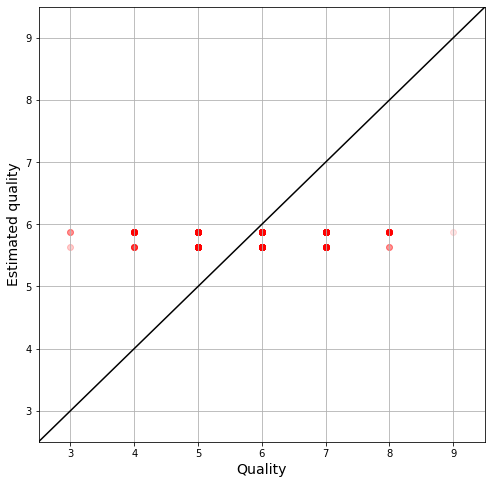

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test_predictions, color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')
plt.grid()
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)
plt.show()

Есть ещё 11 признаков, описывающих химический состав вин

In [20]:
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
3167,white,7.4,0.30,0.49,8.2,0.055,49.0,188.0,0.99740,3.52,0.58,9.7,6
4494,white,6.4,0.44,0.26,2.0,0.054,20.0,180.0,0.99520,3.58,0.57,10.0,5
6495,white,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
5505,white,6.5,0.33,0.30,3.8,0.036,34.0,88.0,0.99028,3.25,0.63,12.5,7
1354,red,7.2,0.58,0.03,2.3,0.077,7.0,28.0,0.99568,3.35,0.52,10.0,5


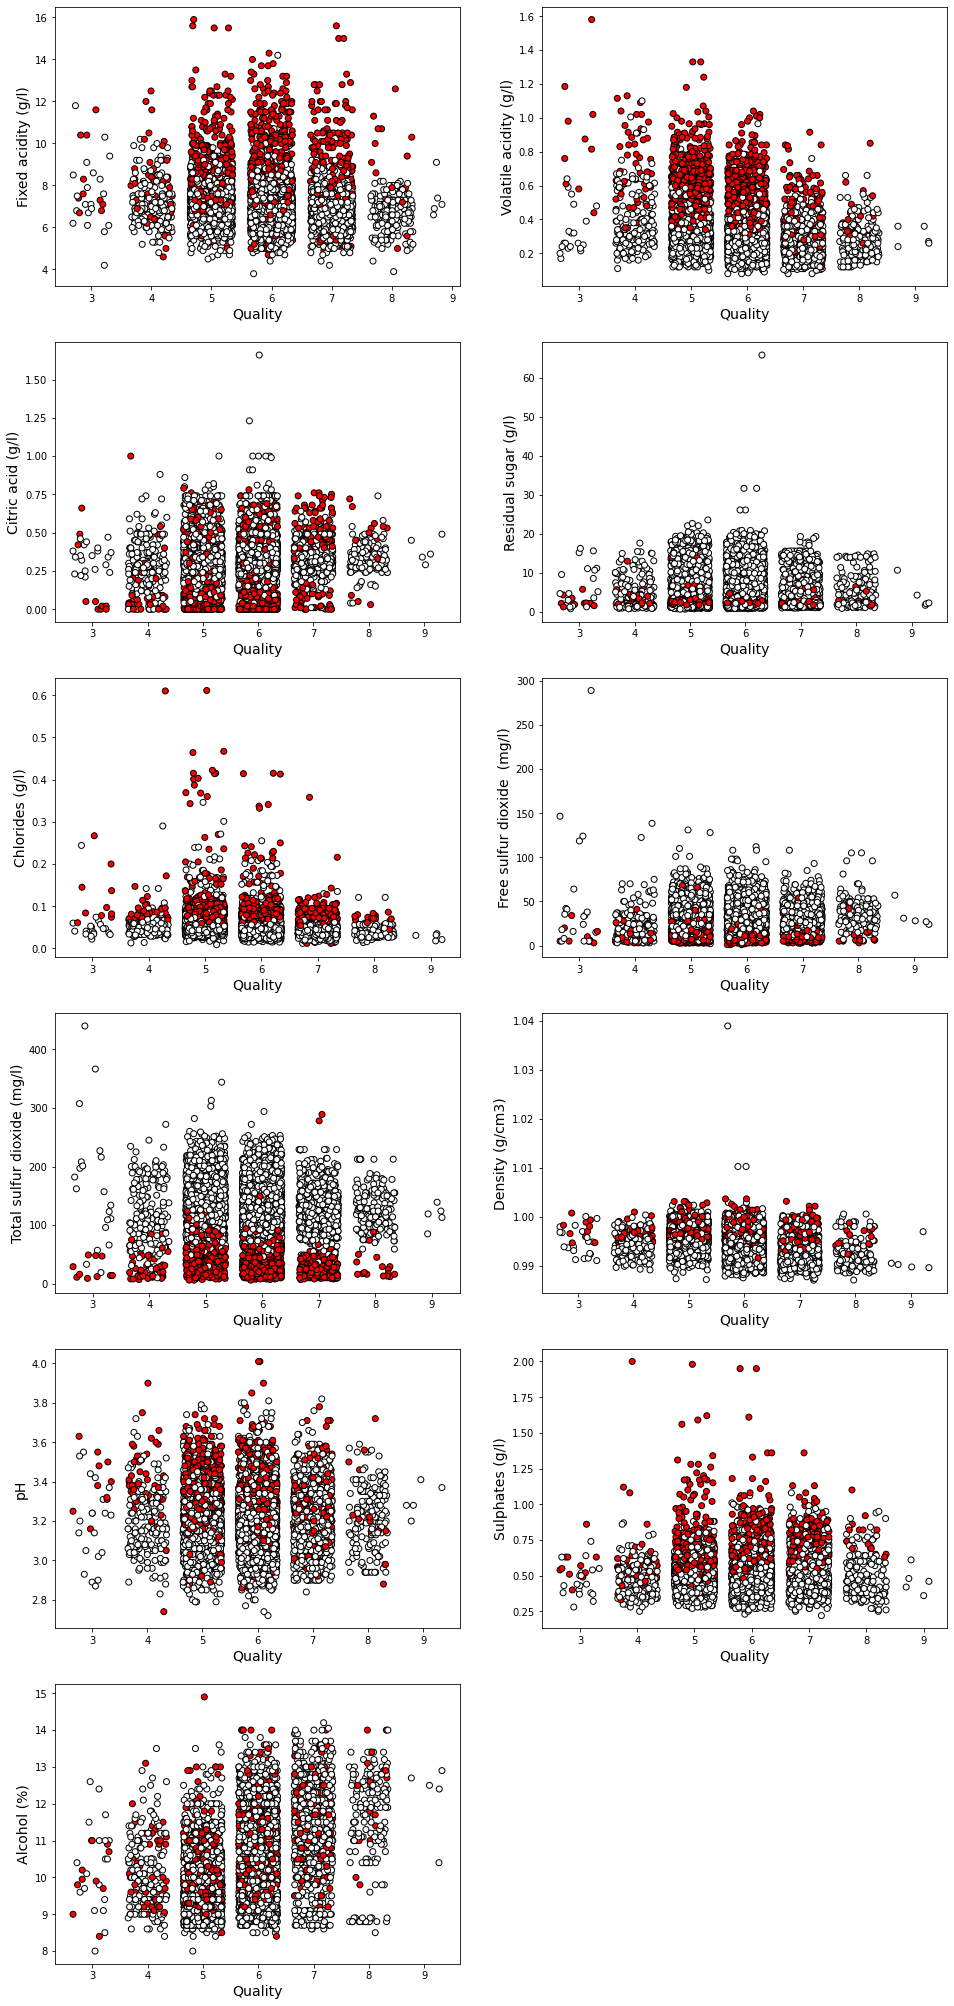

In [21]:
def func(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

plt.figure(figsize=(16, 36))
for i in range (1, 12):
    plt.subplot(6, 2, i)
    plt.scatter(func(wine['quality']), wine.iloc[:, i], color=wine["Type"], edgecolors="black")
    plt.xlabel('Quality', fontsize=14)
    plt.ylabel(str(wine.columns[i]), fontsize=14)
plt.show()

Их также необходимо учесть при построении прогноза оценок!!!

## Линейная регрессия

In [22]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [23]:
mean_squared_error(lm.predict(X_train), y_train) ** 0.5

0.7309451972467509

In [24]:
mean_squared_error(lm.predict(X_test), y_test) ** 0.5

0.7377914473880042

Ошибки предсказания существенно уменьшились

Истинные оценки вин и их предсказания линейной моделью

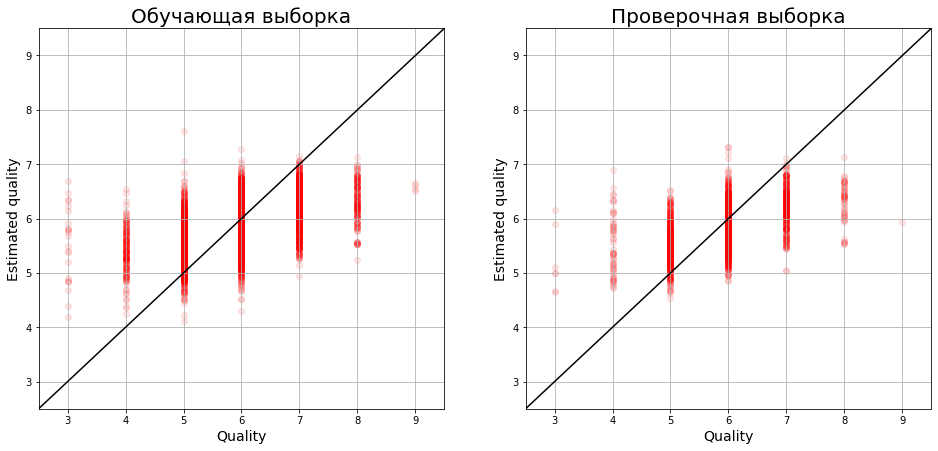

In [25]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')
plt.grid()
plt.title('Обучающая выборка', fontsize=20)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
plt.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')
plt.grid()
plt.title('Проверочная выборка', fontsize=20)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)
plt.show()

Посчитаем коэффициент детерминации - долю объяснённой моделью дисперсии отклика (объясняющими переменными)

In [26]:
lm.score(X_test, y_test)

0.2840752815549161

## Случайный лес

In [27]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)

In [28]:
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=3)

In [29]:
mean_squared_error(rf.predict(X_train), y_train) ** 0.5

0.3466164189793188

In [30]:
mean_squared_error(rf.predict(X_test), y_test) ** 0.5

0.6278660249916374

Качество выросло ещё сильнее, хотя модель и переобучилась

Истинные оценки вин и их предсказания случайным лесом

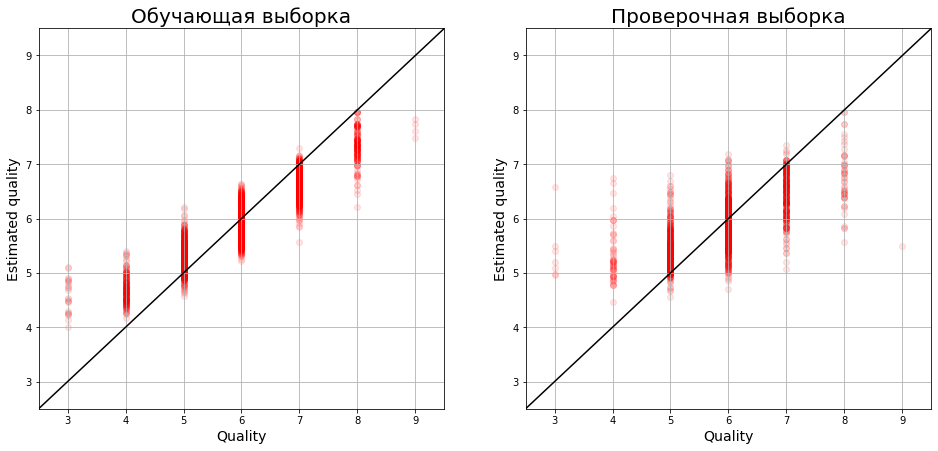

In [31]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')
plt.grid()
plt.title('Обучающая выборка', fontsize=20)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
plt.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')
plt.grid()
plt.title('Проверочная выборка', fontsize=20)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)
plt.show()

Коэффициент детерминации для случайного леса

In [32]:
rf.score(X_test, y_test)

0.4815175139882598

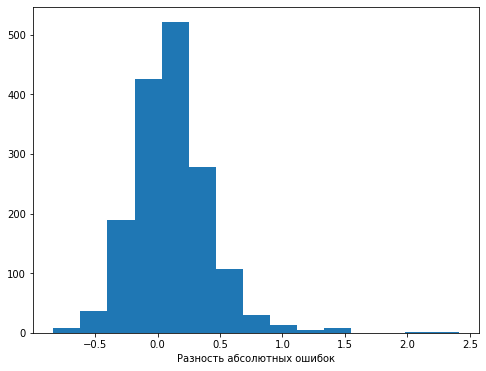

In [33]:
# ошибки линейной регрессии и случайного леса на тестовой выборке в сравнении
plt.figure(figsize=(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15)
plt.xlabel('Разность абсолютных ошибок')
plt.show()

In [34]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

1.8301240160617065e-13

Различия между средними абсолютными ошибками значимы

95% доверительный интервал для средней разности абсолютных ошибок

In [35]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.08448610925005662, 0.1454845548020539)

То есть, используя вместо линейной регрессии случайный лес, предсказание экспертной оценки в среднем точнее

In [36]:
# какие признаки обладают наибольшей предсказательной способностью
importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
11,Alcohol (%),0.286308
2,Volatile acidity (g/l),0.136431
6,Free sulfur dioxide (mg/l),0.084176
10,Sulphates (g/l),0.076913
7,Total sulfur dioxide (mg/l),0.069336
4,Residual sugar (g/l),0.068360
9,pH,0.060294
5,Chlorides (g/l),0.059330
3,Citric acid (g/l),0.054982
8,Density (g/cm3),0.053018


Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя